# Import all libraries needed for this project

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import difflib as dl
import requests 
import time
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Scraping all data from the IGDB API.

In [2]:
# Your Client ID and Access Token (replace with actual values)
client_id = '2s6fe3ts3br2aikeue6v2mvpspjkf3'
access_token = 'grq8ke6nrir3w76qhto0f50zqoa2ql'

# IGDB API endpoint
url = 'https://api.igdb.com/v4/games'

# Headers for the request
headers = {
    'Client-ID': client_id,
    'Authorization': f'Bearer {access_token}',
}

# Fields you want to fetch for each game
fields = '''
fields id, name, rating, rating_count, age_ratings, aggregated_rating, aggregated_rating_count, 
alternative_names, artworks, bundles, category, checksum, collection, collections, cover, created_at, 
dlcs, expanded_games, expansions, external_games, first_release_date, follows, forks, franchise, franchises, 
game_engines, game_localizations, game_modes, genres, hypes, involved_companies, keywords, language_supports, 
multiplayer_modes, parent_game, platforms, player_perspectives, ports, release_dates, remakes, remasters, screenshots, 
slug, standalone_expansions, status, summary, tags, themes, total_rating, total_rating_count, updated_at, url, version_parent, version_title, videos, websites;
where rating != null & rating_count != null & total_rating != null & total_rating_count != null;
'''

In [3]:
# Function to call the IGDB API and fetch data for a specific endpoint
def fetch_data(endpoint):
    url = f'https://api.igdb.com/v4/{endpoint}'
    response = requests.post(url, headers=headers, data='fields id, name; limit 500;')
    data = response.json()
    return {item['id']: item['name'] for item in data if 'id' in item and 'name' in item}

# Fetch relevant data for each field and create a mapping dictionary
franchise_dict = fetch_data('franchises')
game_engine_dict = fetch_data('game_engines')
cover_dict = fetch_data('covers')
game_localizations_dict = fetch_data('game_localizations')
game_modes_dict = fetch_data('game_modes')
companies_dict = fetch_data('companies')  # Involved companies data is in the 'companies' path
language_support_dict = fetch_data('language_supports')
multiplayer_modes_dict = fetch_data('multiplayer_modes')
platform_dict = fetch_data('platforms')
player_perspectives_dict = fetch_data('player_perspectives')
theme_dict = fetch_data('themes')

# Helper function to handle lists of IDs and convert them to names
def format_name_id(data_list, mapping_dict=None):
    if isinstance(data_list, list):  # If it's a list
        formatted_items = []
        for item in data_list:
            if isinstance(item, int):  # Handle case where it's just an ID
                formatted_items.append(f"{mapping_dict.get(item, 'Unknown')} ({item})" if mapping_dict else str(item))
        return '|'.join(formatted_items)
    elif isinstance(data_list, int):  # If it's just a single ID
        return f"{mapping_dict.get(data_list, 'Unknown')} ({data_list})" if mapping_dict else str(data_list)
    return 'N/A'

# Function to fetch all games with pagination and store each game's details in a list
def fetch_all_games(limit=500, fields=''):
    all_games = []
    offset = 0
    game_count = 0  # To keep track of the total number of games

    while True:
        # Build the body with limit and offset to paginate through results
        body = f'{fields} limit {limit}; offset {offset};'
        
        # Make the API request
        response = requests.post('https://api.igdb.com/v4/games', headers=headers, data=body)
        
        # Check if the request was successful
        if response.status_code == 200:
            games = response.json()
            
            # Break the loop if no more games are returned
            if not games:
                print("No more games to fetch.")
                break
            
            # Process each game's details and store them in a list of formatted strings
            for game in games:
                game_info = {
                    'ID': str(game.get('id', 'N/A')),
                    'Name': str(game.get('name', 'N/A')),
                    'Rating': str(game.get('rating', 'N/A')),
                    'Rating Count': str(game.get('rating_count', 'N/A')),
                    'Age Ratings': format_name_id(game.get('age_ratings', [])),
                    'Aggregated Rating': str(game.get('aggregated_rating', 'N/A')),
                    'Aggregated Rating Count': str(game.get('aggregated_rating_count', 'N/A')),
                    'Alternative Names': format_name_id(game.get('alternative_names', [])),
                    'Artworks': format_name_id(game.get('artworks', [])),
                    'Bundles': format_name_id(game.get('bundles', [])),
                    'Category': str(game.get('category', 'N/A')),
                    'Checksum': str(game.get('checksum', 'N/A')),
                    'Collection': str(game.get('collection', 'N/A')),
                    'Collections': format_name_id(game.get('collections', [])),
                    'Cover': str(game.get('cover', 'N/A')),
                    'Cover Name': cover_dict.get(game.get('cover'), 'Unknown'),
                    'Created At': str(game.get('created_at', 'N/A')),
                    'DLCs': format_name_id(game.get('dlcs', [])),
                    'Expanded Games': format_name_id(game.get('expanded_games', [])),
                    'Expansions': format_name_id(game.get('expansions', [])),
                    'External Games': format_name_id(game.get('external_games', [])),
                    'First Release Date': str(game.get('first_release_date', 'N/A')),
                    'Follows': str(game.get('follows', 'N/A')),
                    'Forks': format_name_id(game.get('forks', [])),
                    'Franchise': format_name_id(game.get('franchise', [])),
                    'Franchise Name': format_name_id(game.get('franchise', []), mapping_dict=franchise_dict),
                    'Game Engines': format_name_id(game.get('game_engines', [])),
                    'Game Engine Name': format_name_id(game.get('game_engines', []), mapping_dict=game_engine_dict),
                    'Game Localizations': format_name_id(game.get('game_localizations', [])),
                    'Game Modes': format_name_id(game.get('game_modes', []), mapping_dict=game_modes_dict),
                    'Genres': format_name_id(game.get('genres', [])),
                    'Hypes': str(game.get('hypes', 'N/A')),
                    'Involved Companies': format_name_id(game.get('involved_companies', [])),
                    'Company Names': format_name_id(game.get('involved_companies', []), mapping_dict=companies_dict),
                    'Keywords': format_name_id(game.get('keywords', [])),
                    'Language Supports': format_name_id(game.get('language_supports', []), mapping_dict=language_support_dict),
                    'Multiplayer Modes': format_name_id(game.get('multiplayer_modes', []), mapping_dict=multiplayer_modes_dict),
                    'Platforms': format_name_id(game.get('platforms', []), mapping_dict=platform_dict),
                    'Player Perspectives': format_name_id(game.get('player_perspectives', []), mapping_dict=player_perspectives_dict),
                    'Ports': format_name_id(game.get('ports', [])),
                    'Release Dates': format_name_id(game.get('release_dates', [])),
                    'Remakes': format_name_id(game.get('remakes', [])),
                    'Remasters': format_name_id(game.get('remasters', [])),
                    'Screenshots': format_name_id(game.get('screenshots', [])),
                    'Slug': str(game.get('slug', 'N/A')),
                    'Standalone Expansions': format_name_id(game.get('standalone_expansions', [])),
                    'Status': str(game.get('status', 'N/A')),
                    'Storyline': str(game.get('storyline', 'N/A')),
                    'Tags': format_name_id(game.get('tags', [])),
                    'Themes': format_name_id(game.get('themes', []), mapping_dict=theme_dict),
                    'Theme Name': format_name_id(game.get('themes', []), mapping_dict=theme_dict),
                    'Total Rating': str(game.get('total_rating', 'N/A')),
                    'Total Rating Count': str(game.get('total_rating_count', 'N/A')),
                    'Updated At': str(game.get('updated_at', 'N/A')),
                    'URL': str(game.get('url', 'N/A')),
                    'Version Parent': format_name_id(game.get('version_parent', [])),
                    'Version Title': str(game.get('version_title', 'N/A')),
                    'Videos': format_name_id(game.get('videos', [])),
                    'Websites': format_name_id(game.get('websites', []))
                }
                all_games.append(game_info)
            
            # Update the total game count
            game_count += len(games)
            
            # Increment the offset for the next batch of games
            offset += limit
            
            # Pause to respect rate limits
            time.sleep(0.3)  # Wait 300ms between requests (4 requests per second limit)
        else:
            print(f"Failed to fetch data: {response.status_code}")
            print(response.text)
            break

    print(f"Total games fetched: {game_count}")
    return all_games

# Fetch all the games
games_data = fetch_all_games(limit=500, fields=fields)

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(games_data)

# Save the DataFrame to a CSV file
df.to_csv('igdb_games_data.csv', index=False)

print(f"Game data saved to igdb_games_data.csv with {len(df)} games.")

No more games to fetch.
Total games fetched: 30873
Game data saved to igdb_games_data.csv with 30873 games.


## Let's visualize the table and see how it turned out so far

In [ ]:
# Load the saved data
games_dat = pd.read_csv('igdb_games_data.csv')
games_dat.head()

## Let's clean up duplicate values in the coloumns we specially got ID's and names

In [4]:
# Function to remove duplicates and keep only one column
def clean_duplicate_columns(df, id_column, name_column):
    """
    Remove one of the columns (ID or Name) to avoid duplication.
    If both columns exist, keep only the Name column.
    """
    # Check if both columns exist
    if id_column in df.columns and name_column in df.columns:
        # Drop the ID column, keeping only the Name column
        df.drop(columns=[id_column], inplace=True)

# List of column pairs to clean (ID, Name)
columns_to_clean = [
    ('Themes', 'Theme Name'),
    ('Platforms', 'Platform Name'),
    ('Franchise', 'Franchise Name'),
    ('Game Engines', 'Game Engine Name'),
    ('Involved Companies', 'Company Names'),
    ('Genres', 'Genre Name'),
    # Add other ID-Name column pairs here
]

# Apply the function to clean the duplicate columns for all relevant pairs
for id_col, name_col in columns_to_clean:
    clean_duplicate_columns(df, id_col, name_col)

# Save the cleaned DataFrame to a CSV file
df.to_csv('igdb_games_data.csv', index=False)

print("Cleaned file saved successfully.")

Cleaned file saved successfully.


## Let's visualize the table again

In [5]:
# Load the so far cleaned data
games_dat.head()

,ID,Name,Rating,Rating Count,Age Ratings,Aggregated Rating,Aggregated Rating Count,Alternative Names,Artworks,Bundles,...,Tags,Theme Name,Total Rating,Total Rating Count,Updated At,URL,Version Parent,Version Title,Videos,Websites
0,215217,Tiny Rogues,91.641903,5,162917,NaN,NaN,NaN,86350,NaN,...,1|17|268435461|268435468|268435487|268435488|2...,Action (1)|Fantasy (17),91.641903,5,1725962367,https://www.igdb.com/games/tiny-rogues,NaN,NaN,74227|104239,307462|307463|501746|605460
1,82461,10tons Adventure Puzzles Bundle,60.000000,0,84506,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,60.000000,0,1670990469,https://www.igdb.com/games/10tons-adventure-pu...,NaN,NaN,NaN,440080
2,236547,Thronefall,77.856060,14,NaN,NaN,NaN,NaN,NaN,NaN,...,1|17|21|268435471|268435480|268435488,Action (1)|Fantasy (17)|Survival (21),77.856060,14,1725962530,https://www.igdb.com/games/thronefall,NaN,NaN,97151|118938,528578|556705|570629
3,118128,Little Dungeon Stories,50.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,...,268435468|268435471|268435487|268435488,NaN,50.000000,0,1713262585,https://www.igdb.com/games/little-dungeon-stories,NaN,NaN,NaN,109257|391447
4,10402,Heavy Bullets,60.467833,7,NaN,80.0,1.0,NaN,9037,NaN,...,1|18|27|268435461|268435488|536871038|53687132...,Action (1)|Science fiction (18)|Comedy (27),70.233917,8,1719999714,https://www.igdb.com/games/heavy-bullets,NaN,NaN,5140,44116|44117|238156|397643


# Visualize and Pre processing of game data CSV file 

In [6]:
# check rows and columns
games_dat.shape

(30873, 55)

## We have 55 metrics, but not all of them will be useful. It should also be noted that the intent is to make a content and popularity based system.
### The few metrics that I am certain we will need are: 	
####    •   Genres: Users often prefer specific genres (e.g., action, fantasy). This is a key metric.
####	•	Platforms: Users may prefer games on specific platforms (e.g., PC, PlayStation).
####	•	Game Modes: Single-player or multiplayer preferences are important for users.
####	•	Themes: Similar to genres, but with a different layer of abstraction.
####	•	Involved Companies: Some users prefer games from specific developers or publishers.
####	•	Player Perspectives: The gameplay perspective (e.g., first-person, third-person) can impact preferences.
####	•	Ratings and Rating Count: Popular and highly-rated games are more likely to be recommended.

In [14]:
# Load CSV file
df = pd.read_csv('igdb_games_data.csv')

# Check the data types of the columns
print(df.dtypes)

ID                           int64
Name                        object
Rating                     float64
Rating Count                 int64
Age Ratings                 object
Aggregated Rating          float64
Aggregated Rating Count    float64
Alternative Names           object
Artworks                    object
Bundles                     object
Category                     int64
Checksum                    object
Collection                 float64
Collections                 object
Cover                      float64
Cover Name                  object
Created At                   int64
DLCs                        object
Expanded Games              object
Expansions                  object
External Games              object
First Release Date         float64
Follows                    float64
Forks                       object
Franchise Name              object
Game Engine Name            object
Game Localizations          object
Game Modes                  object
Genres              

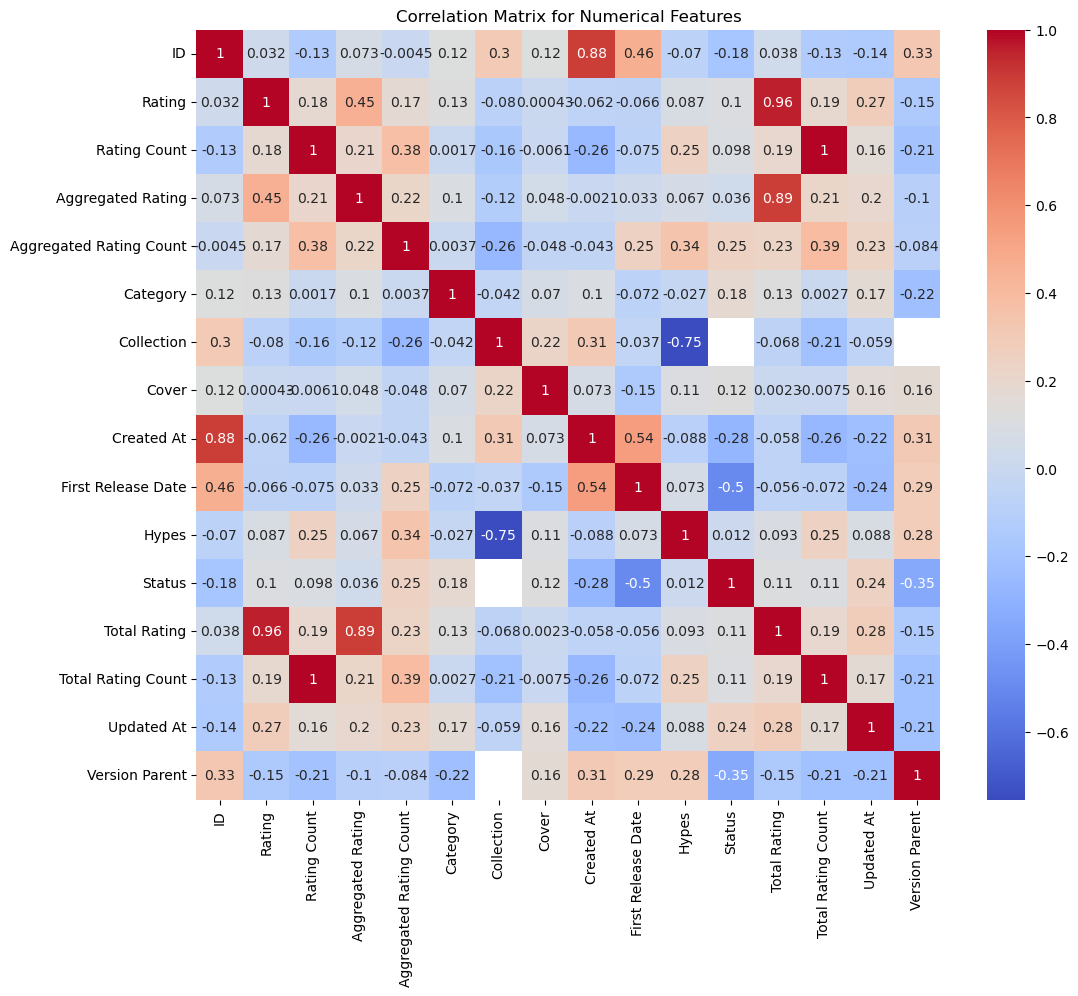

In [15]:
# Select only the numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=[float, int])

# Drop columns that have no variance (i.e., all values are NaN or constant)
numeric_df = numeric_df.dropna(axis=1, how='all').loc[:, (numeric_df != numeric_df.iloc[0]).any()]

# Check if there are any numeric columns left to compute the correlation
if numeric_df.shape[1] > 0:
    # Calculate the correlation matrix
    correlation_matrix = numeric_df.corr()

    # Plot the heatmap for correlation
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix for Numerical Features')
    plt.show()
else:
    print("No numeric columns with variance left to compute the correlation matrix.")

## Observations of the correlation matrix
###	1.	Rating and Total Rating have a very high correlation (0.96), indicating that they are closely related and might represent similar underlying information.
###	2.	Hypes and Collection show a significant negative correlation (-0.75), meaning that games with higher “hypes” tend to belong to collections less frequently.
###	3.	Total Rating Count and Rating Count are highly correlated (1.0), suggesting that they essentially capture the same metric and might be redundant for model training.

In [18]:
#Let's check for missing values in the dataset

numerical_df = df.select_dtypes(include=[np.number])
print(numerical_df.columns)

print(df.describe())

ID                             0
Name                           0
Rating                         0
Rating Count                   0
Age Ratings                14155
Aggregated Rating          20526
Aggregated Rating Count    20526
Alternative Names          18349
Artworks                   14762
Bundles                    26117
Category                       0
Checksum                       0
Collection                 30700
Collections                19691
Cover                       2429
Cover Name                     0
Created At                     0
DLCs                       29117
Expanded Games             30198
Expansions                 30340
External Games               401
First Release Date          1044
Follows                    30873
Forks                      30847
Franchise Name             29787
Game Engine Name           25250
Game Localizations         24271
Game Modes                  2622
Genres                      1221
Hypes                      27369
Company Na

## Observations from checking missing values:
### There are 30873 games in our csv file. This means any parameter that is missing more than 14000 values will be omitted. 
### The reason for doing so is that since there are missing values, the similarity matrix can't get display the correct picture on how they react with other metrics and hence can't be used in our system

# Now we select the relevant features

In [37]:
print("Total Rating:")
print("Min:", df['Total Rating'].min(), "Max:", df['Total Rating'].max())
print()

print("Rating:")
print("Min:", df['Rating'].min(), "Max:", df['Rating'].max())
print()

print("Aggregated Rating:")
print("Min:", df['Aggregated Rating'].min(), "Max:", df['Aggregated Rating'].max())
print()

print("Total Rating Count:")
print("Min:", df['Total Rating Count'].min(), "Max:", df['Total Rating Count'].max())
print()

# Print the min and max for 'Rating Count'
print("Rating Count:")
print("Min:", df['Rating Count'].min(), "Max:", df['Rating Count'].max())
print()

# Use describe to get more details like mean, median, etc.
print("Descriptive Statistics:")
print(df[['Total Rating', 'Rating', 'Aggregated Rating', 'Aggregated Rating Count', 'Total Rating Count', 'Rating Count']].describe())

# Update the original DataFrame to keep only rows where 'Rating Count' is greater than 4
df = df[df['Rating Count'] > 3]

# Save the updated DataFrame back to the same CSV file if needed
df.to_csv('filtered_igdb_games_data.csv', index=False)

print("Original file updated successfully.")

# Load the updated data
selected_columns = ['Genres', 'Theme Name', 'Platforms', 'Total Rating', 'Rating', 'Aggregated Rating', 'Aggregated Rating Count', 'Keywords', 'Game Modes', 'Player Perspectives', 'Multiplayer Modes', 'Company Names']

Total Rating:
Min: 10.01529400246946 Max: 100.0

Rating:
Min: 10.01529400246946 Max: 100.0

Aggregated Rating:
Min: 0.0 Max: 100.0

Total Rating Count:
Min: 4 Max: 4617

Rating Count:
Min: 4 Max: 4580

Descriptive Statistics:
       Total Rating        Rating  Aggregated Rating  Aggregated Rating Count  \
count  14628.000000  14628.000000        8037.000000              8037.000000   
mean      71.763424     71.516770          73.346209                 4.935548   
std       11.984588     12.055008          14.070252                 4.687850   
min       10.015294     10.015294           0.000000                 0.000000   
25%       65.776398     65.602981          67.333333                 2.000000   
50%       73.418908     72.434156          76.000000                 3.000000   
75%       79.950716     79.905154          82.400000                 7.000000   
max      100.000000    100.000000         100.000000                43.000000   

       Total Rating Count  Rating Count  
co

In [40]:
# Load the saved data
games_dat = pd.read_csv('filtered_igdb_games_data.csv')
games_dat.head()
# Fill missing values with empty strings
for columns in selected_columns:
  games_dat[columns] = games_dat[columns].fillna('')


# Function to combine all selected columns into a single string
def combine_columns(row):
    # Convert all items in the row to strings before joining
    return ' '.join([str(item) for item in row])

# Apply the function to combine the selected columns
games_dat['combined_features'] = games_dat[selected_columns].apply(combine_columns, axis=1)

# Display the combined features
print(games_dat['combined_features'].head())

0    5|12|31|32|33 Action (1)|Fantasy (17) PC (Micr...
1    15|24|32 Action (1)|Fantasy (17)|Survival (21)...
2    5|32 Action (1)|Science fiction (18)|Comedy (2...
3    12|15|24|35 Fantasy (17) Linux (3)|PC (Microso...
4    4 Action (1) PlayStation (7)|Dreamcast (23) 80...
Name: combined_features, dtype: object


In [ ]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()